There's too much going on in Gordon's notebook to resolve any issues we're having with an individual plot.  Construct the L--z plot in this single notebook.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import richardsplot as rplot
import palettable
from astropy.cosmology import FlatLambdaCDM; cosmo = FlatLambdaCDM(Om0=0.3, H0=70)
from astropy.table import Table

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
plt.rcParams['xtick.top']   = True
plt.rcParams['ytick.right'] = True

#use this color palette throughout
cs = palettable.colorbrewer.qualitative.Dark2_5.mpl_colors

In [3]:
def plot_contour(xdata, ydata, c="k", mark=".", nlevels=3, ax=None, linewidths=0.5, s=3, alpha=1, label=None):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min()-0.25*abs(xdata.mean()), xdata.max()+0.25*abs(xdata.mean())
    ymin, ymax = ydata.min()-0.25*abs(ydata.mean()), ydata.max()+0.25*abs(ydata.mean())
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    z = kernel(values)
    
    #transform Z to a 0-1 range
    Z = (Z - Z.min())/(Z.max() - Z.min())
    z = (z - z.min())/(z.max() - z.min())
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=linewidths, colors=[c]).levels
    
    # mask points above density threshold
    x = np.ma.masked_where(z > levels[0], xdata)
    y = np.ma.masked_where(z > levels[0], ydata)
    ax.scatter(x, y, color=c, marker=mark, s=3, alpha=alpha, zorder=2, label=label)

---

Load data.  First from HST; includes 130 S07 objects and additional 78 HSLA objects with ICA.  N=208

In [4]:
hst = pd.read_csv("/Users/Trevor1/Dropbox/HST/final_tables/HST_CIV_Sulentic2007_HSLA2018_1Jan2023.csv")
#comment out next line if want to include "bad" CIV measurements
hst = hst[hst["CIVgood_tvm"].values==1]
hst.head()

,Final_Name,Name_sul07,z,z_src,r_z_sul07,CIV_blue_tvm,CIV_EW_tvm,CIVgood_tvm,CIV_blue_sul07,CIV_EW_sul07,...,MBH_source,logEddRatio,EddRatio_Source,SDSS_NAME,PLATE,MJD,FIBERID,IAU_sul07,_RA,_DE
0,PG1322+659,PG 1322+659,0.1674,Sul,M03,542.446498,58.743636,1,310.0,65.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J13238+6541,200.956198,65.696727
1,Mrk205,MRK 0205,0.0711,Sul,M03,266.508764,88.957267,1,73.0,52.077562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J12217+7518,185.433196,75.310553
3,LBQS1138+0204,LBQS 1138+0204,0.3821,Sul,SDSS,1024.717970,9.097499,1,536.0,33.333333,...,NaN,NaN,NaN,114121.75+014803.5,514.0,51994.0,285.0,J11413+0148,175.340622,1.800953
4,J15395+4735,[HB89] 1538+477,0.7723,Sul,M03,611.392209,33.244469,1,402.0,64.876033,...,NaN,NaN,NaN,153934.80+473531.2,6729.0,56419.0,258.0,J15395+4735,234.895083,47.592000
5,3C110,3C 110,0.7744,Sul,SPM,-493.636575,59.969524,1,-983.0,80.198020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J04172-0553,64.319917,-5.896000


In [5]:
hst.columns

Index(['Final_Name', 'Name_sul07', 'z', 'z_src', 'r_z_sul07', 'CIV_blue_tvm',
       'CIV_EW_tvm', 'CIVgood_tvm', 'CIV_blue_sul07', 'CIV_EW_sul07',
       'F1450_spec (erg/s/cm2/A)', 'S2N_1450A', 'Inst_final', 'log M_BH',
       '+err(log M_BH)', '-err(log M_BH)', 'MBH_source', 'logEddRatio',
       'EddRatio_Source', 'SDSS_NAME', 'PLATE', 'MJD', 'FIBERID', 'IAU_sul07',
       '_RA', '_DE'],
      dtype='object')

In [6]:
names_hst = hst["Final_Name"].values

z_hst    = hst["z"].values
DLcm_hst = cosmo.luminosity_distance(z_hst).value*3.086e24 #convert Mpc to cm 

#compute luminosities in erg/s/Hz
#first convert flambda to fnu
fnu1450_hst    = hst["F1450_spec (erg/s/cm2/A)"].values * 1450. / (2.998e18/1450)
logLnu1450_hst = np.log10(4.*np.pi) + np.log10(fnu1450_hst) + 2*np.log10(DLcm_hst)

In [7]:
maskMBH = (~np.isnan(hst["log M_BH"].values))

---

And plot -- plan is to plot everything "as is".  That is, if there's no ICA measurement for a dataset, I'm not plotting it so we know where we stand.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


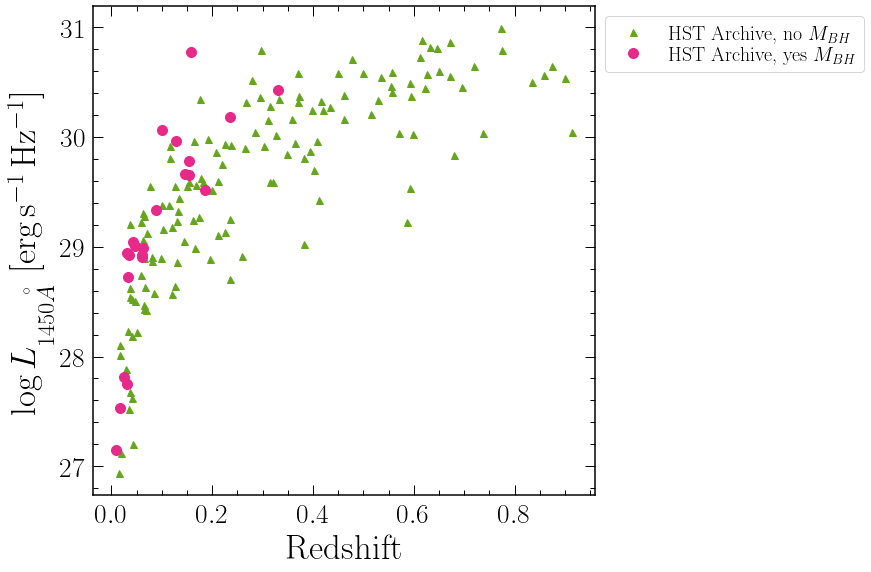

In [8]:
ALPHA_ORIG = 0.25

##
fig, ax = plt.subplots(1, 1, figsize=(9,9))

###Next block of code plots the HST sample
#plot ICA measurements
ax.plot(z_hst[~maskMBH], logLnu1450_hst[~maskMBH], marker="^", markersize=7, color=cs[4], label="HST Archive, no $M_{BH}$", linestyle="")
ax.plot(z_hst[maskMBH], logLnu1450_hst[maskMBH], marker="o", markersize=10, color=cs[3], label="HST Archive, yes $M_{BH}$", linestyle="")

#plot settings
ax.set_xlabel('Redshift', fontsize=35)
ax.set_ylabel(r'log\,$L_{1450\AA}$ [erg\,s$^{-1}$\,Hz$^{-1}$]', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=27.5)
ax.legend(frameon=True, labelspacing=0.1, bbox_to_anchor=(1.0,1), prop={"size":20})

#ax.set_ylim(-499.99, 5999)
#plt.xlim(26.5,32.3)
plt.show()

<hr style="border:15px solid gray">

Now include SDSS objects.  For now, these are ~145,000 DR14 objects with CIV from Rankine+20. 

To remain as consistent as possible with the HST objects, I pulled L1350 measurements from Wu & Shen's spectral properties of DR16.

In [9]:
sdss_tbl = Table.read("/Users/Trevor1/Dropbox/catalogs/Rankine20_CIV_HeII_wDelGI_wdr16luminosity.fits")
names = [name for name in sdss_tbl.colnames if len(sdss_tbl[name].shape) <= 1]
sdss = sdss_tbl[names].to_pandas()
#next line cuts objects without luminosity at logL1350 (15828/145946, maybe just not in spectra?)
sdss = sdss[(sdss["LOGL1350_dr16"]>0)&(sdss["good"]==True)]
sdss.head()

,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,CIV_EW,...,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,EBV_dr16,LOGL1350_dr16,LOGL2500_dr16
0,b'003708.46+002855.8',9.285266,0.482174,3.02295,True,False,False,True,691.966469,75.072475,...,0.032006,45.552314,-0.018692,3.531072,-1.0,-1.0,0.600,0.020385,45.751832,45.721232
1,b'004959.24+001903.1',12.496858,0.317540,3.32150,True,False,False,True,857.180965,32.148782,...,-0.079175,12.024832,-0.040529,3.323599,-1.0,-1.0,0.375,0.016264,45.808613,0.000000
2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,31.916310,...,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,0.032827,46.482924,46.471169
3,b'023238.49-001936.2',38.160390,-0.326749,3.34348,True,False,False,True,715.316626,40.857802,...,-0.042674,229.386872,0.313899,1.875008,-1.0,-1.0,0.831,0.020306,46.151251,0.000000
4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,106.332340,...,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.053382,45.686672,45.869747


In [10]:
lognuLnu1350_sdss = sdss["LOGL1350_dr16"].values
logLnu1350_sdss   = lognuLnu1350_sdss - np.log10(2.9918e18/1350)

z_sdss = sdss["z_paul"].values

---

Now add GNIRS-DQS.  Found 196/226 matches to Rankine+20.

In [11]:
gnirs = pd.read_csv("/Users/Trevor1/Dropbox/catalogs/gnirsdqs_wRankine_wdr16Lum.csv")
gnirs = gnirs[((gnirs["good"]==True)&(gnirs["LOGL1350_dr16"].values>0))]
gnirs

,SDSS,FWHM-Hb,EW-Hb,EW-Fe2,RA,DEC,z_paul,good,CIV_blue,CIV_EW,FIRST_FLUX,Delta_G_I,EBV_dr16,LOGL1350_dr16,LOGL2500_dr16,Separation
0,b' J010615.93+101043.0',2936,73,2,16.566375,10.178611,2.349550,True,1370.747782,29.741127,-1.00,0.255,0.038158,46.468226,46.339400,0.076726
1,b' J141617.38+264906.1',4574,29,9,214.072417,26.818361,2.303360,True,5184.405058,10.884853,2.94,0.820,0.013895,46.429107,46.634516,0.058456
2,b' J011538.72+242446.0',3925,51,34,18.911333,24.412778,2.389560,True,1980.043140,26.444624,-1.00,0.014,0.043618,46.825398,46.619689,0.090241
3,b' J093533.88+235720.5',6686,94,2,143.891167,23.955694,2.303190,True,342.276646,43.004758,-1.00,0.072,0.022259,46.803522,46.736122,0.085507
5,b' J114350.30+362911.3',4090,48,13,175.959583,36.486472,2.356160,True,1548.446448,21.157348,-1.00,0.098,0.016090,47.013947,46.895565,0.087221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,b' J093251.98+023727.0',5521,48,31,143.216583,2.624167,2.164804,True,1555.979001,39.276915,-1.00,0.235,0.038693,46.362684,46.518544,0.039926
218,b' J144706.81+212839.2',6113,56,14,221.778375,21.477556,3.224680,True,501.942026,29.929695,1.09,0.149,0.023042,46.857125,0.000000,0.090962
219,b' J160552.97+292141.4',4192,64,2,241.470708,29.361500,2.325757,True,659.730040,55.427849,-1.00,0.438,0.033625,46.580814,46.706964,0.076767
221,b' J233344.66+290251.5',4068,55,45,353.436083,29.047639,3.203430,True,1605.023478,24.404962,-1.00,0.375,0.149675,46.676641,0.000000,0.075988


In [12]:
lognuLnu1350_gnirs    = gnirs["LOGL1350_dr16"].values
logLnu1350_gnirs      = lognuLnu1350_gnirs - np.log10(2.998e18/1350)

z_gnirs = gnirs["z_paul"].values

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


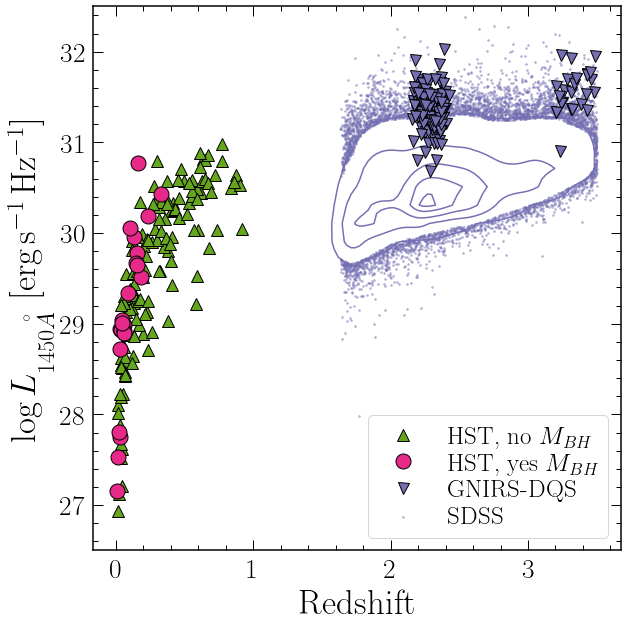

In [13]:
ALPHA_ORIG = 0.25
fig, ax = plt.subplots(1, 1, figsize=(9,9))

### Next block of code plots the HST sample
#plot ICA measurements
ax.plot(z_hst[~maskMBH], logLnu1450_hst[~maskMBH], marker="^", markersize=12, 
        markerfacecolor=cs[4], markeredgecolor="k", label="HST, no $M_{BH}$", linestyle="", zorder=3)
ax.plot(z_hst[maskMBH], logLnu1450_hst[maskMBH], marker="o", markersize=15, 
        markerfacecolor=cs[3], markeredgecolor="k", label="HST, yes $M_{BH}$", linestyle="", zorder=3)


### Next block of code plots SDSS and GNIRS-DQS objects
#N.B. this block takes a while, so should comment out when testing
plot_contour(z_sdss, logLnu1350_sdss, c=cs[2], mark="o", nlevels=[0.05, 0.25, 0.50, 0.75, 0.95], ax=ax, 
             linewidths=1.5, s=3, alpha=0.4, label="SDSS")
#ax.plot(z_sdss, logLnu1350_sdss, marker="o", markersize=3, color=cs[2], alpha=0.35, 
#        label="SDSS", linestyle="", zorder=1)

#now GNIRS
ax.plot(z_gnirs, logLnu1350_gnirs, marker="v", markersize=11, markerfacecolor=cs[2], markeredgecolor="k", label="GNIRS-DQS", linestyle="", zorder=3)

#plot settings
ax.set_xlabel('Redshift', fontsize=35)
ax.set_ylabel(r'log\,$L_{1450\AA}$ [erg\,s$^{-1}$\,Hz$^{-1}$]', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=27.5)
#ax.legend(frameon=True, labelspacing=0.1, bbox_to_anchor=(1.0,1), prop={"size":20})
ax.legend(frameon=True, labelspacing=0.1, loc="lower right", prop={"size":25})

ax.set_ylim(26.5, 32.5)
ax.set_xlim(-0.16575, 3.67435)

plt.tight_layout()
plt.savefig("plots/L_versus_z_ICA.pdf")
plt.show()